In [1]:
import os, shutil
from glob import glob
import numpy as np
import random

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
from torchvision import transforms
from torchvision import models
import torch
from torch import Tensor
import torch.optim as optim
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import ImageFolder
import torch.utils.data as Data

In [2]:
def clean_train_test(clss):
    tst = "./test/" + clss + "/*"
    train = "./train/" + clss + "/*"
    tst_files, train_files = glob(tst), glob(train)
    for f in tst_files:
        os.remove(f)
    for f in train_files:
        os.remove(f)

def create_train_test():
    if not os.path.exists("./train") and not os.path.exists("./test"):
        os.makedirs("./train")
        os.makedirs("./test")

    classes = ["cane", "cavallo", "elefante", "farfalla", "gallina", "gatto", "mucca", "pecora", "ragno", "scoiattolo"]
    for clss in classes:
        clss_source = "./input/" + clss
        clean_train_test(clss)

        
        allFileNames = os.listdir(clss_source)
        np.random.shuffle(allFileNames)
        test_ratio = 0.3
        train_FileNames, test_FileNames = np.split(np.array(allFileNames), [int(len(allFileNames)* (1 - test_ratio))])
        train_FileNames = [clss_source+'/'+ name for name in train_FileNames.tolist()]
        test_FileNames = [clss_source+'/' + name for name in test_FileNames.tolist()]

        for name in train_FileNames:
            shutil.copy(name, './train/' + clss)

        for name in test_FileNames:
            shutil.copy(name, './test/' + clss)

In [4]:
# create_train_test()

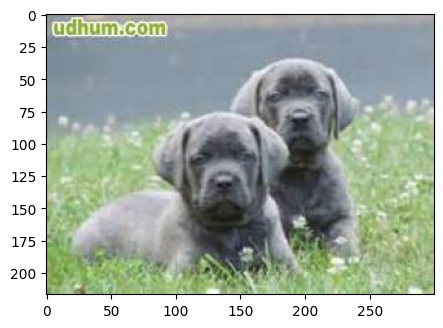

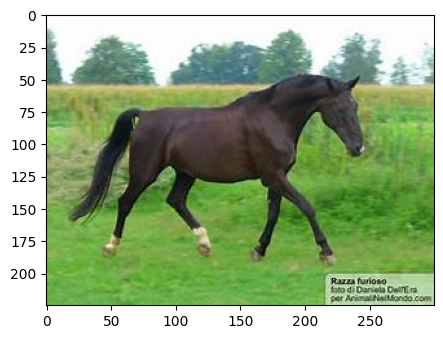

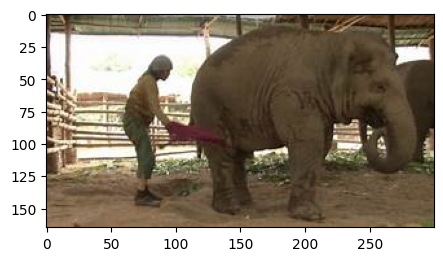

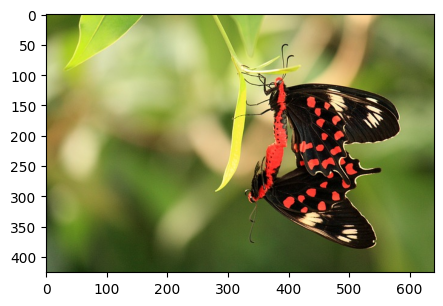

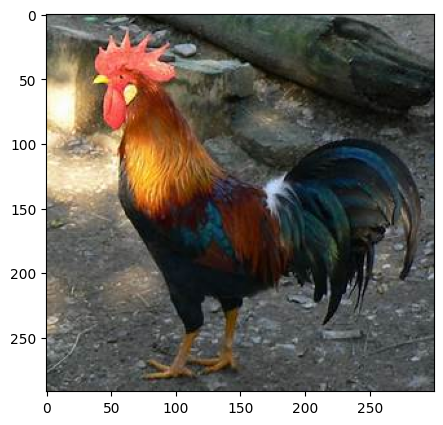

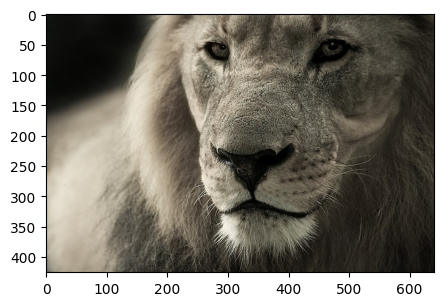

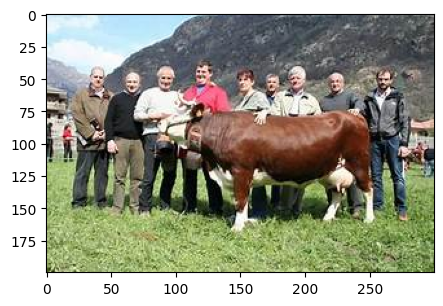

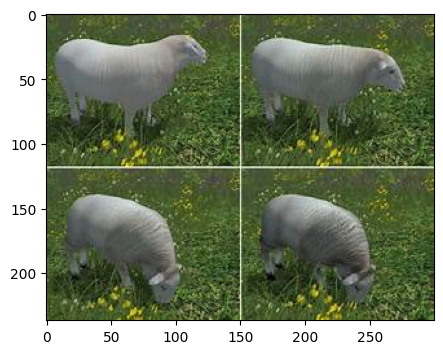

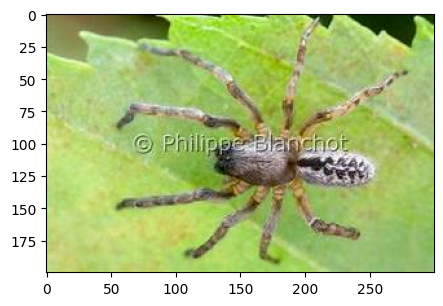

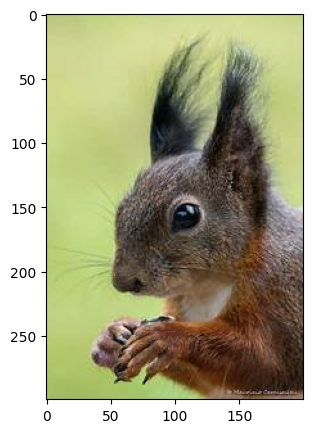

In [5]:
train_dir = "./train"
test_dir = "./test"

train_folder = ImageFolder(train_dir)
test_folder = ImageFolder(test_dir)

for path in os.listdir(train_dir):
    temp_path = os.path.join(train_dir, path)
    file = random.choice(os.listdir(temp_path))
    img_path = os.path.join(temp_path, file)

    img = mpimg.imread(img_path)
    plt.figure(figsize=(5,5))
    plt.imshow(img)

In [6]:
IMG_HEIGHT = 200
IMG_WIDTH = 200

def create_ds(dir):
    img_data_array, class_name = [], []

    classes = {"cane":          [1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
               "cavallo":       [0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
               "elefante":      [0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
               "farfalla":      [0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
               "gallina":       [0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
               "gatto":         [0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
               "mucca":         [0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
               "pecora":        [0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
               "ragno":         [0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
               "scoiattolo":    [0, 0, 0, 0, 0, 0, 0, 0, 0, 1]}
    
    for path in os.listdir(dir):
        for file in os.listdir(os.path.join(dir, path)):
            img_path = os.path.join(dir, path, file)

            img = cv2.imread(img_path, cv2.COLOR_BGR2RGB)

            img = cv2.resize(img, (IMG_HEIGHT, IMG_WIDTH), interpolation=cv2.INTER_AREA)

            img = np.array(img).astype("float64")

            img /= 255

            if len(img.shape) == 3:
                img_data_array.append(np.array(img).reshape([3, IMG_HEIGHT, IMG_WIDTH]))
                class_name.append(classes[path])
        return img_data_array, class_name

In [7]:
train_img_data, train_class_names = create_ds(train_dir)
test_img_data, test_class_names = create_ds(test_dir)

print(len(train_img_data))
print(len(test_img_data))

train_class_names[0]

3404
1459


[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [8]:
print(torch.__version__)


2.3.1+cu121


In [10]:
train_ds = Data.TensorDataset(
    torch.Tensor(np.array(train_img_data)),
    torch.Tensor(np.array(train_class_names))
)

test_ds = Data.TensorDataset(
    torch.Tensor(np.array(test_img_data)),
    torch.Tensor(np.array(test_class_names))
)

trainloader = Data.DataLoader(
    train_ds,
    batch_size=8,
    shuffle=True
)

testloader = Data.DataLoader(
    test_ds,
    batch_size=8,
    shuffle=True
)

dataiter = iter(trainloader)
images = next(dataiter)
images[0].shape

torch.Size([8, 3, 200, 200])

In [11]:
class CNNNet(nn.Module):
    def __init__(self):
        super(CNNNet, self).__init__()

        self.cnn_layers = nn.Sequential(
            # Define a 2D convolution layer with 3 input channels, 16 output channels, and a 5x5 kernel
            nn.Conv2d(3, 16, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2)),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            # Define another convolution layer with 16 input channels, 3 output channels, and a 50x50 kernel
            nn.Conv2d(16, 3, kernel_size=(50, 50), stride=(1, 1)),
            nn.MaxPool2d(kernel_size=1, stride=1, padding=0, ceil_mode=False)
        )

        self.linear_layers = nn.Sequential(
            nn.Linear(3, 10)
        )

    # Define the forward pass
    def forward(self, x):
        x = self.cnn_layers(x)
        x = x.view(x.size(0), -1)
        x = self.linear_layers(x)
        return x

# Define the model, optimizer, and loss function
model = CNNNet()  # Create an instance of the CNNNet class
optimizer = optim.SGD(model.parameters(), lr=0.0001)  # Define the optimizer with a learning rate of 0.001
criterion = nn.CrossEntropyLoss()  # Define the loss function as Cross-Entropy Loss

# Check if GPU is available and move the model and loss function to the GPU if it is
print("CUDA Available:", torch.cuda.is_available())
if torch.cuda.is_available():
    model = model.to("cuda")
    criterion = criterion.to("cuda")

# Print the model architecture
print(model)

CUDA Available: True
CNNNet(
  (cnn_layers): Sequential(
    (0): Conv2d(3, 16, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 3, kernel_size=(50, 50), stride=(1, 1))
    (4): MaxPool2d(kernel_size=1, stride=1, padding=0, dilation=1, ceil_mode=False)
  )
  (linear_layers): Sequential(
    (0): Linear(in_features=3, out_features=10, bias=True)
  )
)


In [12]:
# Training the model for 10 epochs
for i in range(10):
    running_loss = 0
    model.train()  # Set the model to training mode
    for images, labels in trainloader:
        if torch.cuda.is_available():
            images = images.to("cuda")
            labels = labels.to("cuda")

        # Reset the gradients to zero
        optimizer.zero_grad()

        # Forward pass
        output = model(images)

        # Calculate the loss
        loss = criterion(output, labels)

        # Backpropagation
        loss.backward()

        # Update the model's weights
        optimizer.step()

        running_loss += loss.item()
    else:
        # Print the training loss for the current epoch
        print("Epoch {} - Training loss: {}".format(i + 1, running_loss / len(trainloader)))

Epoch 1 - Training loss: 0.25260507655133246
Epoch 2 - Training loss: 0.019329775269077698
Epoch 3 - Training loss: 0.010067004069878321
Epoch 4 - Training loss: 0.00672719775515438
Epoch 5 - Training loss: 0.005020557345408168
Epoch 6 - Training loss: 0.00399294668497592
Epoch 7 - Training loss: 0.0033096304177547076
Epoch 8 - Training loss: 0.0028198771040035112
Epoch 9 - Training loss: 0.0024557729482463835
Epoch 10 - Training loss: 0.0021777995455569583


In [13]:
savepath = "./output/model.pt"

torch.save(model.state_dict(), savepath)

In [14]:
# Create empty lists to store predicted and true labels
y_pred_list = []  # Predicted labels
y_true_list = []  # True labels

# Disable gradient calculations for inference
with torch.no_grad():
    for x_batch, y_batch in testloader:
        x_batch, y_batch = x_batch.to("cuda"), y_batch.to("cuda")
        
        # Perform inference with the model
        y_test_pred = model(x_batch)
        print(y_test_pred)  # Display the model's predictions
        
        # Find the predicted class labels
        _, y_pred_tag = torch.max(y_test_pred, dim=1)
        
        # Extend the lists with the predicted and true labels
        y_pred_list.extend(y_pred_tag.cpu().numpy())
        y_true_list.extend(y_batch.cpu().numpy())

tensor([[13.3822,  0.6678, -2.4826,  0.4956, -2.4856, -2.1004,  4.0646, -4.3068,
         -1.5919,  0.5452],
        [13.3927,  0.6717, -2.4624,  0.4775, -2.4811, -2.0959,  4.0869, -4.3222,
         -1.5939,  0.5297],
        [ 9.9492,  0.5209, -1.6725,  0.2829, -1.8652, -1.5350,  3.0572, -3.1671,
         -1.0472,  0.2615],
        [ 9.2781,  0.4521, -1.5175,  0.2229, -1.7807, -1.4341,  2.8651, -2.9498,
         -0.9544,  0.2017],
        [ 8.7840,  0.4413, -1.4315,  0.2258, -1.6866, -1.3579,  2.6912, -2.7669,
         -0.8704,  0.1856],
        [10.6890,  0.5330, -1.8357,  0.3078, -2.0149, -1.6584,  3.2881, -3.4226,
         -1.1721,  0.3107],
        [12.2254,  0.5991, -2.1969,  0.4020, -2.2920, -1.9110,  3.7401, -3.9333,
         -1.4158,  0.4367],
        [ 9.6869,  0.5051, -1.6626,  0.3118, -1.8297, -1.5054,  2.9354, -3.0520,
         -1.0038,  0.2781]], device='cuda:0')
tensor([[12.2155,  0.6168, -2.2156,  0.4303, -2.2770, -1.9105,  3.7152, -3.9150,
         -1.4066,  0.4548],
 

In [15]:
y_true_list_max = [m.argmax() for m in y_true_list]

In [16]:
correct_count, all_count = 0, 0

# Compare predicted labels (y_pred_list) with true labels (y_true_list_max)
for i in range(len(y_pred_list)):
    if y_pred_list[i] == y_true_list_max[i]:
        correct_count += 1
    all_count += 1

# Calculate and print the model accuracy
accuracy = correct_count / all_count
print("Model Accuracy =", accuracy)

Model Accuracy = 1.0
